In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import progressbar
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time
%matplotlib inline

In [2]:
filter_dim, filter_dim2 = 11, 1
batch_size = 4
image_dim, result_dim = 96, 86
input_layer, first_layer, second_layer, third_layer, output_layer = 4, 17, 9, 4, 1
learning_rate = .01
epochs = 300

In [3]:
def get_variance(training_target):
    '''
    returns variance of the target data. used in normalizing the error.
    '''
    all_pixels = training_target.flatten()
    return all_pixels.var()

def normalize_input(train_data, test_data):
    '''
    normailizing input across each pixel an each channel (i.e. normalize for each input to network).
    '''
    mean, std_dev = np.mean(train_data, axis=0), np.std(train_data, axis=0)
    return (train_data - mean) / std_dev, (test_data - mean) / std_dev

def get_epoch(x, y, n):
    '''
    splits entire data set into an epoch with minibatch of size n. returns a dict with key being the 
    minibatch number and the value being a length 2 list with the features in first index and 
    targets in the second.
    '''
    input_size = x.shape[0]
    number_batches = input_size // n
    extra_examples = input_size % n
    batches = {}
    batch_indices = np.arange(input_size)
    np.random.shuffle(batch_indices)
    for i in range(number_batches):
        temp_indices = batch_indices[n*i:n*(i+1)]
        temp_x = []
        temp_y = []
        for j in temp_indices:
            temp_x.append(x[j])
            temp_y.append(y[j])
        batches[i] = [np.asarray(temp_x), np.asarray(temp_y)]
    if extra_examples != 0:
        extra_indices = batch_indices[input_size-extra_examples:input_size]
        temp_x = []
        temp_y = []
        for k in extra_indices:
            temp_x.append(x[k])
            temp_y.append(y[k])
        batches[i+1] = [np.asarray(temp_x), np.asarray(temp_y)]
    return batches

In [4]:
# data input
data_path = 'https://raw.githubusercontent.com/michaelneuder/image_quality_analysis/master/data/sample_data/'

# train data --- 500 images, 96x96 pixels
orig_500 = pd.read_csv('{}orig_500.txt'.format(data_path), header=None, delim_whitespace = True)
recon_500 = pd.read_csv('{}recon_500.txt'.format(data_path), header=None, delim_whitespace = True)

# test data --- 140 images, 96x96 pixels
orig_140 = pd.read_csv('{}orig_140.txt'.format(data_path), header=None, delim_whitespace = True)
recon_140 = pd.read_csv('{}recon_140.txt'.format(data_path), header=None, delim_whitespace = True)

# train target --- 500 images, 86x86 pixels (dimension reduction due no zero padding being used)
ssim_500 = pd.read_csv('{}ssim_500_nogauss.csv'.format(data_path), header=None)
ssim_140 = pd.read_csv('{}ssim_140_nogauss.csv'.format(data_path), header=None)

# train target --- 500 images, 86x86 pixels (dimension reduction due no zero padding being used)
ssim_500_old = pd.read_csv('{}SSIM_500.txt'.format(data_path), header=None, delim_whitespace=True)
ssim_140_old = pd.read_csv('{}SSIM_140.txt'.format(data_path), header=None, delim_whitespace=True)

In [5]:
# getting 4 input channels for train and test --- (orig, recon, orig squared, recon squared)
original_images_train = orig_500.values
original_images_train_sq = orig_500.values**2
reconstructed_images_train = recon_500.values
reconstructed_images_train_sq = recon_500.values**2

original_images_test = orig_140.values
original_images_test_sq = orig_140.values**2
reconstructed_images_test = recon_140.values
reconstructed_images_test_sq = recon_140.values**2

# stack inputs
training_input = np.dstack((original_images_train, reconstructed_images_train, original_images_train_sq, reconstructed_images_train_sq))
testing_input = np.dstack((original_images_test, reconstructed_images_test, original_images_test_sq, reconstructed_images_test_sq))

# normalize inputs
training_input_normalized, testing_input_normalized = normalize_input(training_input, testing_input)

# target values
training_target = ssim_500.values
testing_target = ssim_140.values

# target values 2
training_target2 = ssim_500_old.values
testing_target2 = ssim_140_old.values

In [6]:
# get size of training and testing set
train_size = original_images_train.shape[0]
test_size = original_images_test.shape[0]

# reshaping features to (num images, 96x96, 4 channels)
train_features = np.reshape(training_input_normalized, [train_size,image_dim,image_dim,input_layer])
test_features =  np.reshape(testing_input_normalized, [test_size,image_dim,image_dim,input_layer])

# reshaping target to --- (num images, 86x86, 1)
train_target = np.reshape(training_target, [train_size, result_dim, result_dim, output_layer])
test_target = np.reshape(testing_target, [test_size, result_dim, result_dim, output_layer])

# reshaping target2 to --- (num images, 96x96, 1)
train_target2 = np.reshape(training_target2, [train_size, image_dim, image_dim, output_layer])
test_target2 = np.reshape(testing_target2, [test_size, image_dim, image_dim, output_layer])

# inverse 
train_features = -1*train_features
test_features = -1*test_features

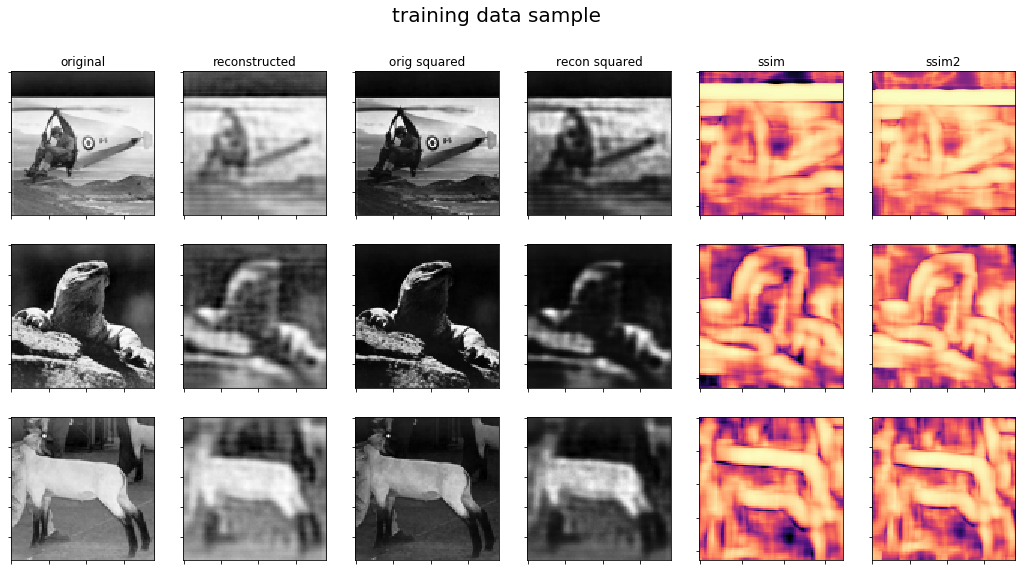

In [7]:
f, axarr = plt.subplots(nrows=3,ncols=6, figsize=(18,9))
for i in range(3):
    axarr[i,0].imshow(train_features[i,:,:,0], cmap='Greys')
    axarr[i,1].imshow(train_features[i,:,:,1], cmap='Greys')
    axarr[i,2].imshow(train_features[i,:,:,2], cmap='Greys')
    axarr[i,3].imshow(train_features[i,:,:,3], cmap='Greys')
    axarr[i,4].imshow(train_target[i,:,:,0], cmap='magma')
    axarr[i,5].imshow(train_target2[i,:,:,0], cmap='magma')

axarr[0,0].set_title('original')
axarr[0,1].set_title('reconstructed')
axarr[0,2].set_title('orig squared')
axarr[0,3].set_title('recon squared')
axarr[0,4].set_title('ssim')
axarr[0,5].set_title('ssim2')
for ax_row in axarr:
    for ax in ax_row:
        ax.set_xticklabels([])
        ax.set_yticklabels([])

f.suptitle('training data sample', size=20)
plt.savefig('compare_ssim.png')
plt.show()